In [62]:
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType
from ufl import (TrialFunction, Measure, TestFunction, grad, div, inner, lhs, rhs)

import random
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from utils.dolfinx import BoundaryCondition, generate_boundary_measure, project
from meshes import rectangle_builder

from pathlib import Path

In [74]:
time_save_dir = "/root/Meshes/rectangle-model/time"
Path(time_save_dir).mkdir(parents=True, exist_ok=True)

## Implementation of Time-Domain problem

In [75]:
def time_domain_problem_setup(config, mesh_data):    
    """
    Perform problem configuration of time domain problem
    w.r.t. given parameters. Add new information to config.
    
    Parameters
    ----------
    config : dict
        Configuration parameters required for problem setup
    """
    
    # ---------------------------------------------------------------
    #               Mesh and function space definition
    # ---------------------------------------------------------------
    domain, mt, ft = mesh_data
    dx = Measure('dx', subdomain_data=mt, domain=domain)
    ds = Measure("ds", subdomain_data=ft, domain=domain)
    
    V = fem.VectorFunctionSpace(domain, ("CG", 2))

    u = TrialFunction(V)
    v = TestFunction(V)

    # ---------------------------------------------------------------
    #        Definition physical characteristics functions
    # ---------------------------------------------------------------
    fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
    
    ro, c, eta = fluids.loc[[config['problem']['fluid'], 
                             config['problem']['contaminant']], 
                            ['Density', 'Speed of sound', 'Viscosity']].T.values

    # ---------------------------------------------------------------
    #               Construction of problem form
    # ---------------------------------------------------------------
    GAMMA, BETA = 0.5, 0.5
    dt = config['problem']['dt']

    mm = ScalarType(ro[0]) * inner(u, v) * dx(1)
    aa = ScalarType(ro[0] * c[0]**2) * inner(grad(u), grad(v)) * dx(1)
    cc = ScalarType(4./3 * eta[0]) * inner(grad(u), grad(v)) * dx(1)

    if len(config['mesh']['bubble_centres']) > 0:
        mm += ScalarType(ro[1]) * inner(u, v) * dx(2)
        aa += ScalarType(ro[1] * c[1]**2) * inner(grad(u), grad(v)) * dx(2)
        cc += ScalarType(4./3 * eta[1]) * inner(grad(u), grad(v)) * dx(2)
    
    F = mm + (dt * GAMMA * cc) + (0.5 * dt**2 * BETA * aa)
    
    # ---------------------------------------------------------------
    #               Definition of boundary conditions
    # ---------------------------------------------------------------
    measure = generate_boundary_measure([], domain, ft)
    
    u_D = lambda x: [x[0] * 0.0, x[1] * 0.0, x[2] * 0.0]
    u_N1 = fem.Constant(domain, ScalarType((config['problem']['pressure'], 0, 0)))
    u_N2 = fem.Constant(domain, ScalarType((0, 0, 0)))

    bcs = [BoundaryCondition("Dirichlet", 3, u_D, V, u, v, measure).bc,
           BoundaryCondition("Dirichlet", 2, u_D, V, u, v, measure).bc]
     
    nbcs = [BoundaryCondition("Neumann", 1, u_N1, V, u, v, measure).bc,
            BoundaryCondition("Neumann", 1, u_N2, V, u, v, measure).bc] 
    
    # ---------------------------------------------------------------
    #                      Update config
    # ---------------------------------------------------------------
    config['problem']['function_space'] = {
        'domain': domain,
        'V': V,
        'u': u,
        'v': v,
        'dx': dx,
        'ds': ds
    }
    config['problem']['physical_properties'] = {
        'ro': ro, 
        'c': c, 
        'eta': eta
    }
    config['problem']['forms'] = {
        'M': mm,
        'A': aa,
        'C': cc,
        'F': F
    }
    config['problem']['boundary_conditions'] = {
        'Dirichlet': bcs,
        'Neumann': nbcs
    }

In [76]:
def solve_time_domain_problem(config):
    # ----------------------------------------------------------------
    #                   Obtaining the required data
    # ----------------------------------------------------------------

    domain, V, ds, dx = config['problem']['function_space']['domain'], \
                        config['problem']['function_space']['V'], \
                        config['problem']['function_space']['ds'], \
                        config['problem']['function_space']['dx']

    mm, aa, cc, F = config['problem']['forms']['M'], \
                    config['problem']['forms']['A'], \
                    config['problem']['forms']['C'], \
                    config['problem']['forms']['F']

    bcs, nbcs = config['problem']['boundary_conditions']['Dirichlet'], \
                config['problem']['boundary_conditions']['Neumann']
    
    ro, c = config['problem']['physical_properties']['ro'], \
            config['problem']['physical_properties']['c'],
    
    T, dt = config['problem']['T'], \
            config['problem']['dt']

    # ----------------------------------------------------------------
    #              Configuring path for storing results
    # ----------------------------------------------------------------
    
    if config['results']['file_prefix']:
        PREFIX = f"N_{config['mesh']['N']}_" \
                 f"_br_{str(config['mesh']['bubble_radius']).split('.')[1]}" \
                 f"_bl_{'_'.join(str(int(pct * 100)) for pct in config['mesh']['bubble_lvl'])}_"
    else:
        PREFIX = ''
    
    U_PATH = f"{time_save_dir}/{PREFIX}uj.xdmf"
    PRESSURE_PATH = f"{time_save_dir}/{PREFIX}pressure.xdmf"

    xdmf_u, xdmf_p = None, None
    if config['results']['save_mesh_to_file']:
        xdmf_u = io.XDMFFile(domain.comm, U_PATH, "w")
        xdmf_p = io.XDMFFile(domain.comm, PRESSURE_PATH, "w")
        xdmf_u.write_mesh(domain)
        xdmf_p.write_mesh(domain)
    
    # ----------------------------------------------------------------
    #                   Create initial condition
    # ----------------------------------------------------------------
    initial_condition = lambda x: [x[0] * 0.0, x[1] * 0.0, x[2] * 0.0]
    
    uj = fem.Function(V)
    uj_d = fem.Function(V)
    uj_dd = fem.Function(V)
    uj_d_d_tg = fem.Function(V)
    
    uj.interpolate(initial_condition)
    uj_d.interpolate(initial_condition)
    uj_dd.interpolate(initial_condition)
    uj_d_d_tg.interpolate(initial_condition)
    
    p = project(ro[0] * c[0]**2 * div(uj), domain, ("CG", 2))
    
    # ----------------------------------------------------------------
    #     Constructing left-hand side matrix and setuping solver
    # ----------------------------------------------------------------
    bilinear_form = fem.form(lhs(F))
    
    A = fem.petsc.assemble_matrix(bilinear_form, bcs=bcs)
    A.assemble()
    
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(config['petsc']['solver'])
    solver.getPC().setType(config['petsc']['pc'])

    # ----------------------------------------------------------------
    #   Constructing right-hand side vectors for pulsing pressure
    # ----------------------------------------------------------------   
    GAMMA, BETA = 0.5, 0.5
    uj_d_d_tg.x.array[:] = dt * GAMMA * uj_d.x.array
        
    L1 = nbcs[0] + (cc * uj_d) + (aa * uj) + (aa * uj_d_d_tg)
    L2 = nbcs[1] + (cc * uj_d) + (aa * uj) + (aa * uj_d_d_tg)
    linear_form_1 = fem.form(rhs(L1))
    linear_form_2 = fem.form(rhs(L2))
    
    b1 = fem.petsc.create_vector(linear_form_1)
    b2 = fem.petsc.create_vector(linear_form_2)

    # ----------------------------------------------------------------
    #               Solving problem at each time step
    # ----------------------------------------------------------------
    results = []
    
    t = 0.0
    apply_t = config['problem']['pt']
    
    # p_save_step = np.round(np.array(config['problem']['control_time']) / dt)
    num_steps = int(T / dt)
    p_save_step = list(range(num_steps))
    # p_save_step = []
    for i in range(num_steps):
        # ------------------------------------------------------------
        # Multiply values of uj_d by dt and GAMMA, 
        # because form does not support muliplication by constant
        # ------------------------------------------------------------
        uj_d_d_tg.x.array[:] = uj_d.x.array * dt * GAMMA

        # ------------------------------------------------------------
        #            Setting pulsing pressure at time `t`
        # ------------------------------------------------------------
        if apply_t > 0 and apply_t <= config['problem']['pt']:
            linear_form = linear_form_1         # pressure applied
            b = b1
        elif apply_t < 0:
            apply_t = config['problem']['delay']
            linear_form = linear_form_2         # pressure not applied
            b = b2
        else:
            linear_form = linear_form_2         # pressure not applied
            b = b2

        apply_t -= dt
        t += dt

        # ------------------------------------------------------------
        #       Assembling right-hand side vector at time `t`
        # ------------------------------------------------------------
        with b.localForm() as loc_b:
            loc_b.set(0)
        fem.petsc.assemble_vector(b, linear_form)

        # ------------------------------------------------------------
        #     Applying Dirichlet boundary condition to the vector
        # ------------------------------------------------------------
        fem.petsc.apply_lifting(b, [bilinear_form], [bcs])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, bcs)

        # ------------------------------------------------------------
        #                   Solving linear problem
        # ------------------------------------------------------------
        if config['logs'] and i % config['results']['save_step'] == 0:
            print(f'Info    : Solving problem (Step: {i})')
        
        solver.solve(b, uj_dd.vector)
        uj_dd.x.scatter_forward()

        # ------------------------------------------------------------
        #                     Updating solution
        # ------------------------------------------------------------
        uj1_d_array = uj_d.x.array + dt * uj_dd.x.array

        uj.x.array[:] = uj.x.array + 0.5 * dt * (uj_d.x.array + uj1_d_array)
        uj_d.x.array[:] = uj1_d_array

        # ------------------------------------------------------------
        #                 Save results into the files
        # ------------------------------------------------------------
        if i in p_save_step:
            p = project(div(uj), domain, ("CG", 2))
            pressure_array = np.copy(p.x.array)
            
            fluid_cells = dx.subdomain_data().find(1)
            p.x.array[:] = pressure_array[:] * ro[0] * c[0]**2

            if len(config['mesh']['bubble_centres']) > 0:
                contamination_cells = dx.subdomain_data().find(2)
                p.x.array[contamination_cells] = pressure_array[contamination_cells] * ro[1] * c[1]**2
            
            p_int = fem.assemble_scalar(fem.form(p * ds(2)))
            results.append(np.round(p_int, 8))
        
        if i % config['results']['save_step'] == 0:
            if config['results']['save_mesh_to_file']:
                p = project(div(uj), domain, ("CG", 2))
                pressure_array = np.copy(p.x.array)
                
                fluid_cells = dx.subdomain_data().find(1)
                p.x.array[:] = pressure_array[:] * ro[0] * c[0]**2

                if len(config['mesh']['bubble_centres']) > 0:
                    contamination_cells = dx.subdomain_data().find(2)
                    p.x.array[contamination_cells] = pressure_array[contamination_cells] * ro[1] * c[1]**2
                
                # p = project(ro * c**2 * div(uj), domain, ("CG", 2))
                
                xdmf_u.write_function(uj, t)
                xdmf_p.write_function(p, t)
    
    # ------------------------------------------------------------
    #                 Closing results files
    # ------------------------------------------------------------
    if config['results']['save_mesh_to_file']:
        xdmf_u.close()
        xdmf_p.close()
    
    if config['logs']:
        print(f'Info    : Done.')
        
    return np.array(results)

## Helper functions

In [77]:
def generate_time_config(bubble_centres, bubble_lvl):
    time_config = {
        'mesh': {
            'N': 40,
            'bubble_radius': 0.05,
            'bubble_centres': bubble_centres,
            'bubble_lvl': bubble_lvl
        },
        'problem': {
            'fluid': 'Water',
            'contaminant': 'Air',
            'pressure': 1e3,
            'T':  3.5e-3, # 1.7e-2,
            'dt': 2e-6, # 8.75e-6,
            'pt': 7e-4, # 8.75e-4 * 1.5,
            'delay': 1.0,
            'control_time': [3.5e-3, 7.5e-3, 10.5e-3, 14e-3, 16.9e-3]
        },
        'petsc': {
            'solver': 'preonly',
            'pc': 'lu'
        },
        'results': {
            'filename': './results/time_problem.csv',
            'save_mesh_to_file': False,
            'file_prefix': False,
            'save_step': 25,
        },
        'logs': False
    }
    return time_config

In [78]:
def read_input(filename):
    input_data = []
    with open(filename, 'r') as input_file:
        for line in input_file:
            cnt_lvl, points = line.strip().split('|')
            bubble_centres = []
            for point in points.split(';'):
                if point == '':
                    break
                bubble_centres.append([float(xy) for xy in point.split(',')])

            input_data.append([[float(lvl) for lvl in cnt_lvl.split(';')], 
                                bubble_centres])
            
    return input_data

In [79]:
def write_results(time_data, filename, write_header=True):
    with open(filename, 'w') as file:
        if write_header:
            file.write(';'.join(f'sg_{i+1}' for i in range(5)))
            file.write(';')
            file.write(';'.join(f't_{i+1}' 
                                  for i in range(len(time_data[0][1]))))
            file.write('\n')
        for data in frequency_data:
            file.write(';'.join(str(c_lvl) for c_lvl in data[0]))
            file.write(';')
            file.write(';'.join(str(p_int) for p_int in data[1]))
            file.write('\n')

## Solution of Time-Domain problem

In [117]:
input_data = read_input('./input/input_s5_1000.txt')
bubble_lvl, bubble_centres = input_data[1]

time_config = generate_time_config(bubble_centres, bubble_lvl)
# time_config['problem']['control_time'][0] = 8e3
time_config['results']['save_mesh_to_file'] = True
time_config['results']['file_prefix'] = False
time_config['results']['save_step'] = 10
time_config['logs'] = True

mesh_data = rectangle_builder.build_mesh(time_config['mesh'], 
                                         MPI.COMM_WORLD, 
                                         0, 
                                         time_config['logs'])

time_domain_problem_setup(time_config, mesh_data)
time_results = solve_time_domain_problem(time_config)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Circle)
Info    : [ 40%] Meshing curve 6 (Circle)
Info    : [ 40%] Meshing curve 7 (Circle)
Info    : [ 50%] Meshing curve 8 (Circle)
Info    : [ 60%] Meshing curve 9 (Circle)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Circle)
Info    : [ 80%] Meshing curve 12 (Circle)
Info    : [ 80%] Meshing curve 13 (Circle)
Info    : [ 90%] Meshing curve 14 (Circle)
Info    : [100%] Meshing curve 15 (Circle)
Info    : Done meshing 1D (Wall 0.00448757s, CPU 0.004848s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 10%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 40%] Mes

In [118]:
print(f'Contamination level: {bubble_lvl}')
print(f'Results: {time_results}')

Contamination level: [0.0, 0.0, 0.1571, 0.1885, 0.0]
Results: [  -0.            0.           -0.         ... -142.38558505 -145.3262637
 -146.54727187]


In [ ]:
# write_results(time_results, f'./results/time/res_1000_p.csv')

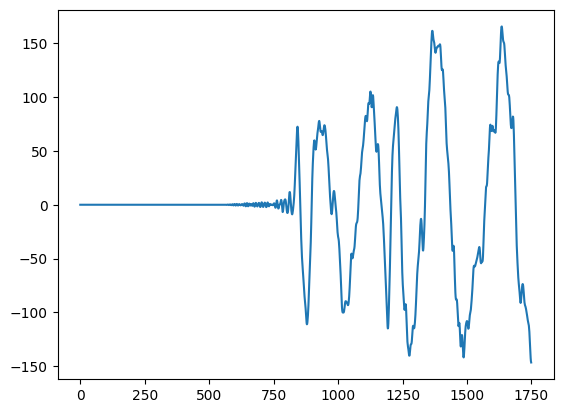

In [120]:
plt.plot(np.array(time_results))

In [123]:
mean_values = np.mean(time_results[:-6].reshape(-1, 4), axis=1)

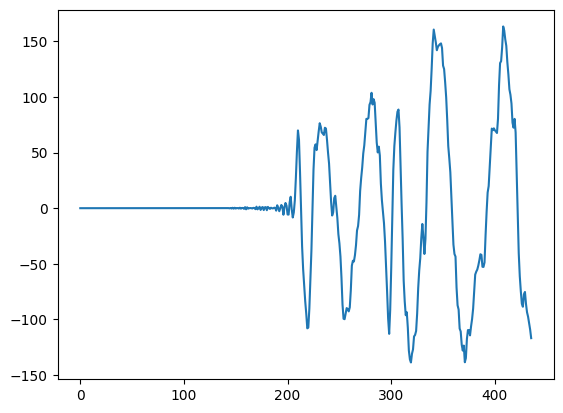

In [124]:
plt.plot(mean_values)